Classifying pictures of Dogs vs Cats. 

We'll begin these exercises with the most basic type of neural network and move into the more modern and complicated kinds. This will also work nicely to move through some of the features of Keras. 

To get started we will load the necessary packages and write some functions to load the data into suitable forms for doing computation on them. This will load the images into numpy arrays that are in the shape (num_pics, channels, width, height).

In [99]:
import os
import numpy as np
from skimage.io import imread, imshow
from skimage import transform

# path to the saved folder from Kaggle and the number of pixels to use for height and width
PATH = 'data/demo'
PIXELS = 64

def load_images(path):
    # read all of the image files in the directory
    names = [d for d in os.listdir(path) if d.endswith('.jpg')]
    
    print 'Making dataset'
    # set up an empty numpy array for our images
    training_images = np.zeros((len(names), 3, PIXELS, PIXELS), dtype=np.float32)
    labels = []
    for i, n in enumerate(names):
        #print n
        img = imread(os.path.join(path, n))
        # skimage loads image as (height, width, channel) for RGB images channels = 3
        img = transform.resize(img, output_shape=(PIXELS, PIXELS , 3), preserve_range=True)
        training_images[i,:,:,:] = img.transpose(2,0,1)
        
        # check the label on the filename and encode the label into integers
        if n.split('.')[0] == 'cat':
            labels.append(0) # I'm sort of a dog person so dogs will be 1
        else:
            labels.append(1)
            
    return training_images, np.asarray(labels)

X_train, y_train = load_images(PATH)

Making dataset


Once we have the data in a suitable form we can check the images to make sure that they look ok. Also to make sure that we didn't mess up the indexing for the labels somehow. 

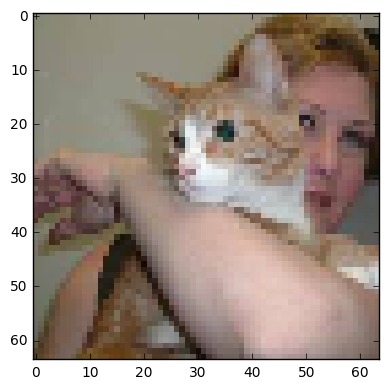

0


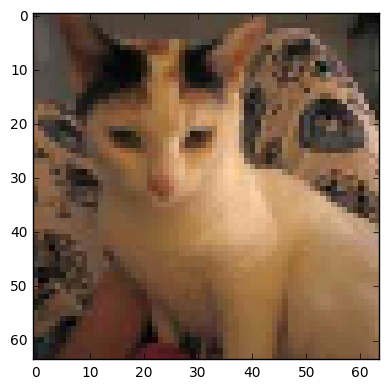

0


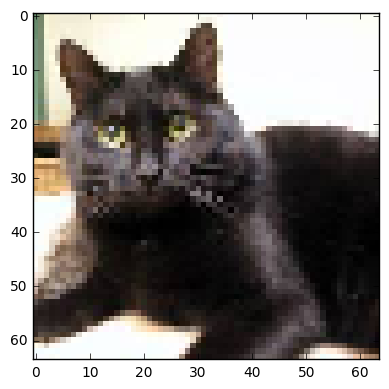

0


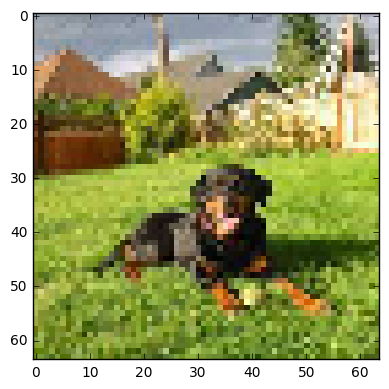

1


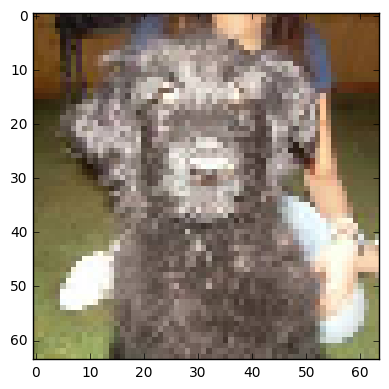

1


In [100]:
from random import randint
%matplotlib inline
from matplotlib import pyplot

def plot_sample(img):
    # we have to tranpose the image back to it's original shape
    # also for some reason imshow in skimage wants images to be float between 0-1 so we divide by it's max
    imshow(img.transpose(1,2,0) / np.amax(img))
    pyplot.show(block=True)

# We'll pick 5 random images, plot them and print their labels
for _ in range(0,5):
    j = randint(0, X_train.shape[0])
    plot_sample(X_train[j])
    print y_train[j]

Now we have our data in a suitable form we can start to train some models on it. 

Since we are going to go in order from simple neural network to modern neural network we will start with a simple linear model. To get a baseline we'll implement it in sklearn. Then do the same exact thing with Keras. 

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle


# have to reshape the images to flat, logistic regression can't handle tensors like ConvNets can
# save this value for that later
num_features = 3*PIXELS*PIXELS

# I'm lazy, which why I like deep learning. So I'll use sklearn to shuffle and split the data
X_train, y_train = shuffle(X_train, y_train)

# should give us 40 training images and 10 testing images to eval performance on
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

logit = LogisticRegression()

logit.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = logit.predict_proba(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds[:,1])

0.57903508771929824

Ok so that wasn't really interesting because it's a logistic regression from sklearn. But, it's essentially the same as the most basic type of neural network. So we'll implement the that type of neural network with a neural network library. The result should be the same.

In [105]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam

logit_input = Input(shape=(num_features,), name='Input', dtype='float32')
probs = Dense(1, activation='sigmoid')(logit_input)
model = Model(input=logit_input, output=probs)

adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = model.predict(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 7.9411 - acc: 0.5056     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     


0.5

OK so that was pretty terrible. But logistic regression is not the right tool for an image recognition task. So lets actually implement some neural networks.

We'll first take the same response that the community had when it was pointed out that a perceptron couldn't solve XOR. The following code will produce a multilayer perceptron. 

In [106]:
mlp_input = Input(shape=(num_features,), name='Input', dtype='float32')

fc1 = Dense(32, activation='relu')(mlp_input)
fc2 = Dense(32, activation='relu')(fc1)
probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=mlp_input, output=probs)
adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = model.predict(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 7.9886 - acc: 0.4981     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 7.9583 - acc: 0.5062     


0.5

That should have done better. I haven't run this yet because I've got a ResNet going. 

So now we'll get to the architectures that kick started the deep learning hype in 2012. Convolutional neural networks. 

In [107]:
from keras.layers import Convolution2D, MaxPooling2D, Flatten

cnn_input = Input(shape=(3, PIXELS, PIXELS), name='Input', dtype='float32')

conv_1 = Convolution2D(8, 3,3, activation='relu')(cnn_input)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Convolution2D(16, 3,3, activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

flat = Flatten()(pool_2)

fc1 = Dense(32, activation='relu')(flat)
fc2 = Dense(32, activation='relu')(fc1)

probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=cnn_input, output=probs)
adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train, y_train)

preds = model.predict(X_test)

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 1.6184 - acc: 0.5106     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 0.9356 - acc: 0.5619     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 0.7699 - acc: 0.5756     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 0.6901 - acc: 0.6162     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 0.6402 - acc: 0.6312     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 0.5992 - acc: 0.6719     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 0.5598 - acc: 0.7081     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 0.5292 - acc: 0.7250     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 0.4977 - acc: 0.7525     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 0.4833 - acc: 0.7694     


0.63280701754385971

The performance was improved but with such a small dataset we can't train a larger more powerful network. If we try something more similar to a modern net we'll overfit like crazy and our test set performance will be terrible. 

In [109]:
cnn_input = Input(shape=(3, PIXELS, PIXELS), name='Input', dtype='float32')

conv_1 = Convolution2D(32, 3,3, activation='relu')(cnn_input)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Convolution2D(64, 3,3, activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3 = Convolution2D(128, 3,3, activation='relu')(pool_2)
pool_3 = MaxPooling2D(pool_size=(2,2))(conv_3)

flat = Flatten()(pool_3)

fc1 = Dense(512, activation='relu')(flat)
fc2 = Dense(512, activation='relu')(fc1)

probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=cnn_input, output=probs)
adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train, y_train)

preds = model.predict(X_test)

roc_auc_score(y_test, preds)

Epoch 1/10
1600/1600 [==============================] - 0s - loss: 7.9848 - acc: 0.4975     
Epoch 2/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 3/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 4/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 5/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 6/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 7/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 8/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 9/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     
Epoch 10/10
1600/1600 [==============================] - 0s - loss: 8.0708 - acc: 0.4937     


0.5

For most practical applications we won't have access to the amount of data necessary to train a really powerful network. Instead we'll use one that's already been trained on millions of natural images across 1000 classes and finetune it to our needs. 

In [110]:
import h5py
from keras.models import Sequential
from keras.layers import Dropout, ZeroPadding2D
from keras.utils.layer_utils import print_summary

# source: https://gist.github.com/zo7/41ce4cccfcfe8f0bff1b4ad82d0ee451
VGG_PATH = 'vgg16_weights.h5'

# only create and load weights to the convolutional part of the VGG16 network
vgg_model = Sequential()
vgg_model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
vgg_model.add(Convolution2D(64, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(64, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, 3, 3, activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

f = h5py.File(VGG_PATH)
for layer in range(f.attrs['nb_layers']):
    # only go as far as deep as our current model
    if layer >= len(vgg_model.layers):
        break
    g = f['layer_{}'.format(layer)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    vgg_model.layers[layer].set_weights(weights)
f.close()
    
model = VGG_16(VGG_PATH)
print_summary(vgg_model.layers)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_183 (ZeroPadding2D)(None, 3, 226, 226)   0           zeropadding2d_input_10[0][0]     
____________________________________________________________________________________________________
convolution2d_232 (Convolution2D)(None, 64, 224, 224)  1792        zeropadding2d_183[0][0]          
____________________________________________________________________________________________________
zeropadding2d_184 (ZeroPadding2D)(None, 64, 226, 226)  0           convolution2d_232[0][0]          
____________________________________________________________________________________________________
convolution2d_233 (Convolution2D)(None, 64, 224, 224)  36928       zeropadding2d_184[0][0]          
___________________________________________________________________________________________

One thing that's important when using a pretrained model is that the input data has to be the exact same format and preprocessed in the same way that the data was for the original model. 

So we have to load the dataset back in a much bigger size. And also do a per channel mean subtraction. The important thing to keep in mind is that the mean from each channel is cominig from the ImageNet dataset not our dataset. 

In [111]:
# path to the saved folder from Kaggle and the number of pixels to use for height and width
PATH = 'data/demo'
PIXELS = 224

def load_images(path):
    # read all of the image files in the directory
    names = [d for d in os.listdir(path) if d.endswith('.jpg')]
    
    print 'Making dataset'
    # set up an empty numpy array for our images
    training_images = np.zeros((len(names), 3, PIXELS, PIXELS), dtype=np.float32)
    labels = []
    for i, n in enumerate(names):
        #print n
        img = imread(os.path.join(path, n))
        # skimage loads image as (height, width, channel) for RGB images channels = 3
        img = transform.resize(img, output_shape=(PIXELS, PIXELS , 3), preserve_range=True)
        training_images[i,:,:,:] = img.transpose(2,0,1)
        
        # check the label on the filename and encode the label into integers
        if n.split('.')[0] == 'cat':
            labels.append(0) # I'm sort of a dog person so dogs will be 1
        else:
            labels.append(1)
            
    return training_images, np.asarray(labels)

X_train, y_train = load_images(PATH)
X_train = X_train[:,[2,1,0],:,:] # swap from RGB to BGR
X_train[:,0,:,:] -= 103.939
X_train[:,1,:,:] -= 116.779
X_train[:,2,:,:] -= 123.68

Making dataset


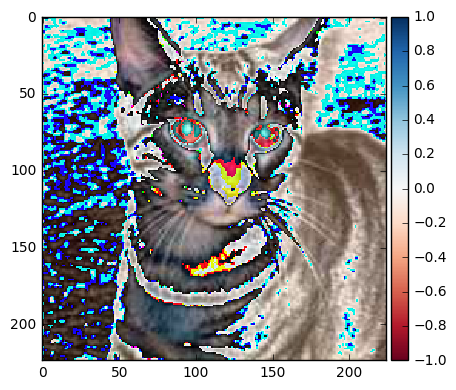

0


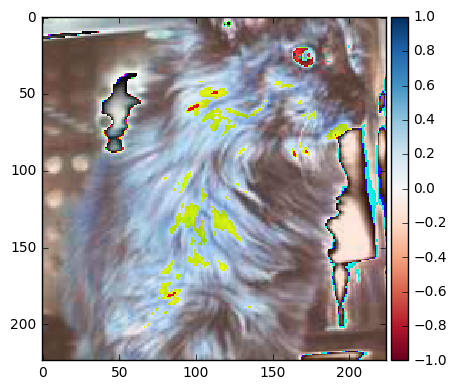

0


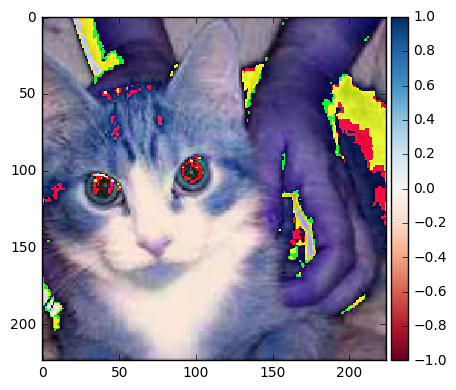

0


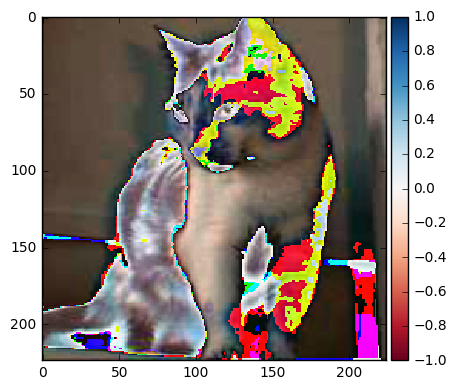

0


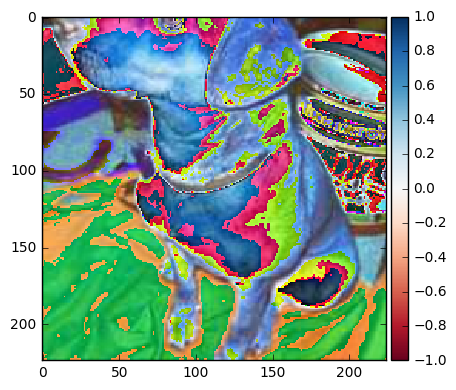

1


In [113]:

def plot_sample(img):
    # we have to tranpose the image back to it's original shape
    # also for some reason imshow in skimage wants images to be float between 0-1 so we divide by it's max
    imshow(img.transpose(1,2,0) / abs(max(np.amax(img), np.amin(img))))
    pyplot.show(block=True)

# We'll pick 5 random images, plot them and print their labels
for _ in range(0,5):
    j = randint(0, X_train.shape[0])
    plot_sample(X_train[j])
    print y_train[j]

The images look pretty trippy this time because we centered each channel around 0 and imshow from skimage doesn't expect negative values. Honestly, the images are better that way. 

In [114]:
# set up training and testing sets again
X_train, y_train = shuffle(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

# Add our own classifier layers on the bottom
vgg_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation='sigmoid'))

# optional set the convolutional layers so they won't be trained.
for layer in vgg_model.layers[:25]:
    layer.trainable = False

adam = Adam(lr=0.0001)
vgg_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

vgg_model.fit(X_train,y_train, nb_epoch=5)

preds = vgg_model.predict(X_test)

roc_auc_score(y_test, preds)

Epoch 1/5
1600/1600 [==============================] - 10s - loss: 0.7692 - acc: 0.8931    
Epoch 2/5
1600/1600 [==============================] - 10s - loss: 0.0561 - acc: 0.9844    
Epoch 3/5
1600/1600 [==============================] - 10s - loss: 0.0303 - acc: 0.9888    
Epoch 4/5
1600/1600 [==============================] - 10s - loss: 0.0119 - acc: 0.9950    
Epoch 5/5
1600/1600 [==============================] - 10s - loss: 0.0024 - acc: 0.9994    


0.99922118380062308

Now we pretty much nailed it. 